<a href="https://colab.research.google.com/github/hussain0048/Projects-/blob/master/Driver_Drowsiness_Detection_System_with_OpenCV_%26_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driver Drowsiness Detection
# **Introduction:**

With this intermediate-level Python project, we will be making a drowsiness detecting device. A countless number of people drive on the highway day and night. Taxi drivers, bus drivers, truck drivers and people traveling long-distance suffer from lack of sleep. Due to which it becomes very dangerous to drive when feeling sleepy.

The majority of accidents happen due to the drowsiness of the driver. So, to prevent these accidents we will build a system using Python, OpenCV, and Keras which will alert the driver when he feels sleepy.[1].

In this Python project, we will be using OpenCV for gathering the images from webcam and feed them into a Deep Learning model which will classify whether the person’s eyes are ‘Open’ or ‘Closed’. The approach we will be using for this Python project is as follows [1] :

Step 1 – Take image as input from a camera.

Step 2 – Detect the face in the image and create a Region of Interest (ROI).

Step 3 – Detect the eyes from ROI and feed it to the classifier.

Step 4 – Classifier will categorize whether eyes are open or closed.

Step 5 – Calculate score to check whether the person is drowsy.

# 1 **Training the Dataset**#

The dataset used for this model is created by us. To create the dataset, we wrote a script that captures eyes from a camera and stores in our local disk. We separated them into their respective labels ‘Open’ or ‘Closed’. The data was manually cleaned by removing the unwanted images which were not necessary for building the model. The data comprises around 7000 images of people’s eyes under different lighting conditions. After training the model on our dataset, we have attached the final weights and model architecture file “models/cnnCat2.h5”.[1]

Now, you can use this model to classify if a person’s eye is open or closed.

#**2-The Model Architecture**
The model we used is built with Keras using Convolutional Neural Networks (CNN). A convolutional neural network is a special type of deep neural network which performs extremely well for image classification purposes. A CNN basically consists of an input layer, an output layer and a hidden layer which can have multiple numbers of layers. A convolution operation is performed on these layers using a filter that performs 2D matrix multiplication on the layer and filter.

The CNN model architecture consists of the following layers:

- Convolutional layer; 32 nodes, kernel size 3
- Convolutional layer; 32 nodes, kernel size 3
- Convolutional layer; 64 nodes, kernel size 3
- Fully connected layer; 128 nodes
- The final layer is also a fully connected layer with 2 nodes. In all the layers, a Relu activation function is used except the output layer in which we used Softmax.

#**3-Prerequisites**

The requirement for this Python project is a webcam through which we will capture images. You need to have Python (3.6 version recommended) installed on your system, then using pip, you can install the necessary packages.

- OpenCV – pip install opencv-python (face and eye detection).
- TensorFlow – pip install tensorflow (keras uses TensorFlow as backend).
- Keras – pip install keras (to build our classification model).
- Pygame – pip install pygame (to play alarm sound).

In [ ]:
pip install pygame

**SciPy**

we can compute the Euclidean distance between facial landmarks points in the eye aspect ratio calculation (not strictly a requirement, but you should have SciPy installed if you intend on doing any work in the computer vision, image processing, or machine learning space)

In [ ]:
!pip install scipy

**imutils package**

We’ll also need the imutils package, my series of computer vision and image processing functions to make working with OpenCV easier.

If you don’t already have imutils  installed on your system, you can install/upgrade imutils  via:

In [ ]:
!pip install --upgrade imutils

 **Playsound library**

 We’ll also import the Thread  class so we can play our alarm in a separate thread from the main thread to ensure our script doesn’t pause execution while the alarm sounds.

In order to actually play our WAV/MP3 alarm, we need the playsound library, a pure Python, cross-platform implementation for playing simple sounds.

The playsound  library is conveniently installable via pip :

In [ ]:
!pip install playsound

# **4-Installing Library** 

In [5]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils.video import VideoStream
from imutils import face_utils
from threading import Thread
import numpy as np
import playsound
import argparse
import imutils
import time
import dlib
import cv2
 

#5 - **Upload Loca files** # 

In [7]:
# this code is used to upload dataset from Pc to colab
from google.colab import files # Please First run this cod in chrom 
def getLocalFiles():
    _files = files.upload() # upload StudentNextSessionf.csv datase
    if len(_files) >0: # Then run above  libray 
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving alarm.wav to alarm.wav


#**6-Play Audio file**
Next, we need to define our sound_alarm  function which accepts a path  to an audio file residing on disk and then plays the file:

In [11]:
def sound_alarm(path):
	# play an alarm sound
	playsound.playsound(path)

# 7- **eye_aspect_ratio**

We also need to define the eye_aspect_ratio  function which is used to compute the ratio of distances between the vertical eye landmarks and the distances between the horizontal eye landmarks:

In [13]:
def eye_aspect_ratio(eye):
	# compute the euclidean distances between the two sets of
	# vertical eye landmarks (x, y)-coordinates
	A = dist.euclidean(eye[1], eye[5])
	B = dist.euclidean(eye[2], eye[4])
	# compute the euclidean distance between the horizontal
	# eye landmark (x, y)-coordinates
	C = dist.euclidean(eye[0], eye[3])
	# compute the eye aspect ratio
	ear = (A + B) / (2.0 * C)
	# return the eye aspect ratio
	return ear

The return value of the eye aspect ratio will be approximately constant when the eye is open. The value will then rapid decrease towards zero during a blink.

If the eye is closed, the eye aspect ratio will again remain approximately constant, but will be much smaller than the ratio when the eye is open.

#8- **Construct the argument parse and parse the arguments** 

In [ ]:
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--shape-predictor", required=True,
	help="path to facial landmark predictor")
ap.add_argument("-a", "--alarm", type=str, default="",
	help="path alarm .WAV file")
ap.add_argument("-w", "--webcam", type=int, default=0,
	help="index of webcam on system")
args = vars(ap.parse_args())

Our drowsiness detector requires one command line argument followed by two optional ones, each of which is detailed below:

- shape-predictor : This is the path to dlib’s pre-trained facial landmark detector. You can download the detector along with the source code to this tutorial by using the “Downloads” section at the bottom of this blog post.
- alarm : Here you can optionally specify the path to an input audio file to be used as an alarm.
- webcam : This integer controls the index of your built-in webcam/USB camera.

# 9- **Define a few important variables:**


In [15]:
# define two constants, one for the eye aspect ratio to indicate
# blink and then a second constant for the number of consecutive
# frames the eye must be below the threshold for to set off the
# alarm
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 48
# initialize the frame counter as well as a boolean used to
# indicate if the alarm is going off
COUNTER = 0
ALARM_ON = False

- EYE_AR_THRESH . If the eye aspect ratio falls below this threshold, we’ll start counting the number of frames the person has closed their eyes for.

##5.1- **1st convolution layer**

In [ ]:
model = Sequential()  
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))  
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))  
# model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))  
model.add(Dropout(0.5))  

## 5.2 - **2nd Convolution Layer**

In [ ]:
model.add(Conv2D(64, (3, 3), activation='relu'))  
model.add(Conv2D(64, (3, 3), activation='relu'))  
# model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))  
model.add(Dropout(0.5)) 

## 5.3- **3rd Convolution Layer**

In [ ]:
model.add(Conv2D(128, (3, 3), activation='relu'))  
model.add(Conv2D(128, (3, 3), activation='relu'))  
# model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))  
model.add(Flatten())  

##5.4-  **Fully connected neural network**

In [ ]:
model.add(Dense(1024, activation='relu'))  
model.add(Dropout(0.2))  
model.add(Dense(1024, activation='relu'))  
model.add(Dropout(0.2))  
model.add(Dense(num_labels, activation='softmax'))  
# model.summary()  

#**6-Training**

##**6.1 Method1 Generator [2]**
We can train the network. To complete the training in less time, I prefer to implement learning with randomly selected trainset instances. That is the reason why train and fit generator used. Also, loss function would be cross entropy because the task is multi class classification [2]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras
import keras.utils
from keras import utils as np_utils

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()
train_generator = gen.flow(X_train, train_y, batch_size=batch_size)
model.compile(loss='categorical_crossentropy'
, optimizer=keras.optimizers.Adam()
, metrics=['accuracy']
)
model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs)

##6.2-**Method 2 Compliling the model**

In [ ]:
model.compile(loss=categorical_crossentropy,  
              optimizer=Adam(),  
              metrics=['accuracy'])  

In [ ]:
model.fit(X_train, train_y,  
          batch_size=batch_size,  
          epochs=epochs,  
          verbose=1,  
          validation_data=(X_test, test_y),  
          shuffle=True)  

#7-**Saving the  model**

In [ ]:
fer_json = model.to_json()  
with open("fer.json", "w") as json_file:  
    json_file.write(fer_json)  
model.save_weights("fer.h5") 

#8-**Evaluate model [2]**

In [ ]:
train_score = model.evaluate(X_train, train_y, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
test_score = model.evaluate(X_test, test_y, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

# **9-Confusion Matrix**[2]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
 
pred_list = []; actual_list = []
 
for i in predictions:
  pred_list.append(np.argmax(i))
 
for i in Y_test:
  actual_list.append(np.argmax(i))
 
confusion_matrix(actual_list, pred_list)
Testing

#**10-Testing**[2]

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


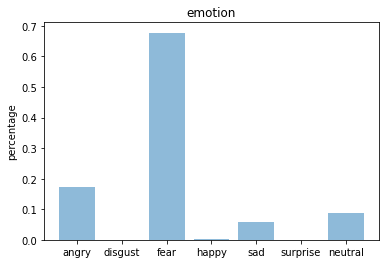

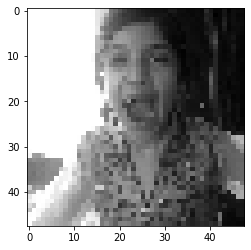

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from matplotlib import pyplot as plt
img = image.load_img("la.jfif", grayscale=True, target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255
custom = model.predict(x)
emotion_analysis(custom[0])
x = np.array(x, 'float32')
x = x.reshape([48, 48]);
plt.gray()
plt.imshow(x)
plt.show()

Emotions stored as numerical as labeled from 0 to 6. Keras would produce an output array including these 7 different emotion scores. We can visualize each prediction as bar chart.

In [ ]:
def emotion_analysis(emotions):
  objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
  y_pos = np.arange(len(objects))
  plt.bar(y_pos, emotions, align='center', alpha=0.5)
  plt.xticks(y_pos, objects)
  plt.ylabel('percentage')
  plt.title('emotion')
  plt.show()

#**11-Detecting Real-Time Emotion**

In [ ]:
import os  
import cv2  
import numpy as np  
from keras.models import model_from_json  
from keras.preprocessing import image  

In [ ]:
#load model  
model = model_from_json(open("fer.json", "r").read())  
#load weights  
model.load_weights('fer.h5') 

In [ ]:
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')  

In [ ]:
cap=cv2.VideoCapture(0)  

In [ ]:
cap=cv2.VideoCapture(0)  
while True:  
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image  
    #if not ret:  
        #continue  
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)  

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)  


    for (x,y,w,h) in faces_detected:  
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)  
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image  
        roi_gray=cv2.resize(roi_gray,(48,48))  
        img_pixels = image.img_to_array(roi_gray)  
        img_pixels = np.expand_dims(img_pixels, axis = 0)  
        img_pixels /= 255  

        predictions = model.predict(img_pixels)  

        #find max indexed array  
        max_index = np.argmax(predictions[0])  

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')  
        predicted_emotion = emotions[max_index]  

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)  

    resized_img = cv2.resize(test_img, (1000, 700))  
    cv2.imshow('Facial emotion analysis ',resized_img)  



    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed  
        break  

cap.release()  
cv2.destroyAllWindows  

References:

[1] Intermediate Python Project – Driver Drowsiness Detection System with OpenCV & Keras
https://data-flair.training/blogs/python-project-driver-drowsiness-detection-system/

[1] Building a Real Time Emotion Detection with Python

https://morioh.com/p/801c509dda99?f=5c21f93bc16e2556b555ab2f

[2] Facial Expression Recognition with Keras
http://sefiks.com/2018/01/01/facial-expression-recognition-with-keras/

[3]Drowsiness detection with OpenCV
https://www.pyimagesearch.com/2017/05/08/drowsiness-detection-opencv/

